# <tt>synphot</tt>: Predicting photometric fluxes of an object observed by SDSS

## Authors
Tiffany Jansen, Brett Morris, Pey Lian Lim, & Erik Tollerud

## Objectives
<ul>
    <li>Query data directly from other websites using <code>astropy.coordinates</code>, <code>astroquery.sdss</code>, and <code>astropy.utils</code></li>
<li>Download spectral data and construct a source spectrum object using <code>synphot.SourceSpectrum</code></li>
<li>Simulate bandpass throughput with <code>synphot.SpectralElement</code></li>
<li>Simulate the photometric observation with <code>synphot.Observation</code></li>
<li>Compute the expected fluxes from this observation with <code>synphot</code>'s <code>effstim()</code> function
</ul>

## Keywords
synphot, synthetic photometry, astropy, astroquery, astronomy

## Summary
<a href="https://synphot.readthedocs.io/en/latest/index.html"><tt>synphot</tt></a> is an astropy-affiliated package for creating synthetic photometry in Python. In this tutorial we will show how to use <tt>synphot</tt> to predict the photometric fluxes of a galaxy observed by SDSS. In particular, we will:
<ol>
<li><a href="#sdss">Get the observed spectrum of our target from SDSS</a></li>
<li><a href="#source_spectrum">Construct a source spectrum object</a></li>
<li><a href="#bandpass">Create the bandpasses of observation</a></li>
<li><a href="#observe">Combine the spectrum with the bandpass throughput and "observe"</a></li>
<li><a href="#compare">Compare predicted flux to observed flux</a></li>
</ol>

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.utils.data import download_file

from astroquery.sdss import SDSS

from synphot import units
from synphot.spectrum import SourceSpectrum, SpectralElement
from synphot.models import Empirical1D
from synphot.observation import Observation

<a id="sdss"></a>
### 1. Download an observed spectrum from SDSS

In this example we choose the galaxy <a href="https://skyserver.sdss.org/dr12/en/tools/explore/Summary.aspx?id=1237662301903192106" target="_blank">IRAS F15163+4255 NW</a> which has a strong H-alpha emission line.

To download the spectrum, first set the coordinates for the object using <a href="https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html" target="_blank"><tt>astropy.coordinates.SkyCoord</tt></a>:

In [17]:
ra = 229.525575754 * u.degree
dec = 42.745853761 * u.degree
coords = SkyCoord(ra, dec)

Then use these coordinates with <a href="https://astroquery.readthedocs.io/en/latest/sdss/sdss.html"><tt>astroquery.sdss</tt></a> to get a .fits file of the spectrum observed by SDSS:

In [18]:
spectrum_fits = SDSS.get_spectra(coordinates=coords)
data = spectrum_fits[0][1].data

Now we can access the data by the keywords given in the .fits header. The wavelengths of the SDSS spectrum are given in a log scale in units of Angstroms, while the flux data from SDSS are scaled by 10<sup>-17</sup> and given in units of ergs/s/cm<sup>2</sup>/Angstroms:

In [19]:
wavelengths = 10 ** data['loglam'] * u.angstrom
flux = data['flux'] * 1e-17 * units.FLAM  # FLAM = ergs/s/cm^2/AA

<a id="source_spectrum"></a>
### 2. Construct a `synphot` source spectrum object from the observed spectrum

To do synthetic photometry with <tt>synphot</tt>, you must first make an object out of your target's spectrum with <a href="https://synphot.readthedocs.io/en/latest/synphot/spectrum.html#arrays"><tt>synphot.spectrum.SourceSpectrum</tt></a>. Since we are constructing the source spectrum from arrays of data, we specify that the model type is Empirical1D and pass in the arrays (e.g. <code>points=wavelengths</code> and <code>lookup_table=flux</code>):

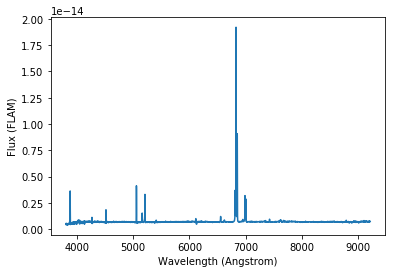

In [20]:
spectrum = SourceSpectrum(Empirical1D,
                          points=wavelengths, lookup_table=flux)

spectrum.plot(flux_unit='FLAM')  # flux units can also be in Jy, PHOTLAM, etc

<a id="bandpass"></a>
### 3. Model the bandpasses

Next we want to model the effect of observing this object through the SDSS bandpasses. Similar to how we made the spectral data into a synphot object, we will also need to construct bandpass objects so that the two can be easily convolved using <tt>synphot</tt>.

To obtain the filter transmission functions of the SDSS bandpasses, we use <a href="https://docs.astropy.org/en/stable/api/astropy.utils.data.download_file.html" target="_blank"><tt>astropy.utils.data.download_file</tt></a> to download the transmission file from the <a href="http://svo2.cab.inta-csic.es/theory/fps/index.php?mode=voservice">Spanish Virtual Observatory</a> filter database. These transmission functions include the effect of the CCD's quantum efficiency on the spectrum.

To construct a bandpass from a file, use <tt>synphot.spectrum</tt>'s <a href="https://synphot.readthedocs.io/en/latest/synphot/spectrum.html"><tt>SpectralElement</tt></a> with its <a href="https://synphot.readthedocs.io/en/latest/api/synphot.spectrum.SourceSpectrum.html#synphot.spectrum.SourceSpectrum.from_file" target="_blank"><tt>from_file</tt></a> method:

In [21]:
# we leave out the u and z bands because they don't
# overlap with the spectrum provided
sdss_bands = ['g', 'r', 'i']
svo_link = ('http://svo2.cab.inta-csic.es/' +
           'theory/fps3/fps.php?ID=SLOAN/SDSS.')

# since we are working with multiple filters I choose to organize
# using a dictionary, but you can do it however works for you
bandpasses = {}
for band in sdss_bands:
    path_to_filt_file = download_file(svo_link + band)
    bp = SpectralElement.from_file(path_to_filt_file)
    bandpasses[band] = bp

You can see how the spectrum overlaps with the bandpasses by plotting the bandpass objects like so:

(0, 0.5)

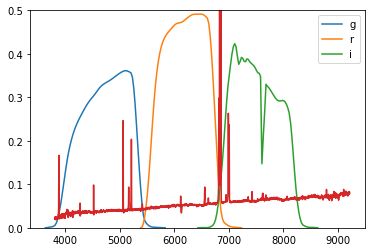

In [22]:
# this is only done in a separate for-loop for example's sake
for band in sdss_bands:
    waveset_band = bandpasses[band].waveset
    plt.plot(waveset_band, bandpasses[band](waveset_band),
             label=band)

waveset_spec = spectrum.waveset
# just so the spectrum overlaps nicely:
scale_down = np.median(spectrum(waveset_spec)) * 20

plt.plot(waveset_spec, spectrum(waveset_spec) / scale_down)
plt.legend(loc='upper right')
plt.ylim(0, 0.5)

<a id="observe"></a>
### 4. Model the observation

We can then model the observation by convolving the object's spectrum with the filter transmission functions using <a href="https://synphot.readthedocs.io/en/latest/synphot/observation.html"><tt>synphot.observation</tt></a>:

In [23]:
obs_obj = {}
for band in sdss_bands:
    obs_obj[band] = Observation(spectrum, bandpasses[band], force='extrap')

We can then use the <tt>synphot.observation</tt> method <a href="https://synphot.readthedocs.io/en/latest/api/synphot.observation.Observation.html?highlight=effstim#synphot.observation.Observation.effstim" target="_blank"><tt>effstim</tt></a> to calculate the total flux obtained in each band. In order to compare our synthetic fluxes to those measured by SDSS, we need to convert the flux to units compatable with SDSS data. <a href="http://www.sdss3.org/dr8/algorithms/magnitudes.php#nmgy" target="_blank">SDSS uses nanomaggies as a flux unit</a>, which we can convert to with the <tt>astropy.units</tt> methods <a href="https://docs.astropy.org/en/stable/api/astropy.units.quantity.Quantity.html#astropy.units.quantity.Quantity.to" target="_blank"><tt>to</tt></a> and <a href="https://docs.astropy.org/en/stable/api/astropy.units.photometric.zero_point_flux.html?highlight=zero%20point%20flux" target="_blank"><tt>zero_point_flux</tt></a> given the zero point of this magnitude scale (3631.1 Jy):

In [24]:
zero_point_star_equiv = u.zero_point_flux(3631.1 * u.Jy)

fluxes = {}
for band in sdss_bands:
    flux = obs_obj[band].effstim('Jy')
    fluxes[band] = flux.to(u.nanomaggy, zero_point_star_equiv)
    print(band + ' =', str(int(fluxes[band].value)) + ' nmgy')

g = 144 nmgy
r = 256 nmgy
i = 397 nmgy


<a id="compare"></a>
### 5. How well does <tt>synphot</tt> do?

To compare the g,r,i empirical fluxes to what we predict with <tt>synphot</tt>, we first get the fluxes measured by the SDSS fibers by using <a href="https://astroquery.readthedocs.io/en/latest/api/astroquery.sdss.SDSSClass.html#astroquery.sdss.SDSSClass.query_crossid"><tt>astroquery.sdss.query_crossid</tt></a> and setting the photoObj to "fiberFlux_band". For a full list of photoObj fields, <a href="https://skyserver.sdss.org/dr12/en/help/browser/browser.aspx?cmd=description+PhotoObj+V#&&history=description+PhotoObj+V">see here</a>.

In [25]:
model_flux = ['fiberFlux_' + band for band in sdss_bands]
flux_table = SDSS.query_crossid(coordinates = coords, photoobj_fields=model_flux)
sdss_fluxes = {}
for band in sdss_bands:
    # sdss fluxes are given in units of "nanomaggies"
    sdss_fluxes[band] = flux_table['fiberFlux_' + band] * u.nanomaggy

/Users/tiffanyjansen/anaconda3/lib/python3.7/site-packages/astroquery/sdss/core.py:856: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))


In [26]:
sdss_fluxes

{'g': <Quantity [110.8969] nmgy>,
 'r': <Quantity [190.9089] nmgy>,
 'i': <Quantity [294.157] nmgy>}

Compare the <tt>synphot</tt> fluxes to the observed fluxes by plotting on a 1-1 line:

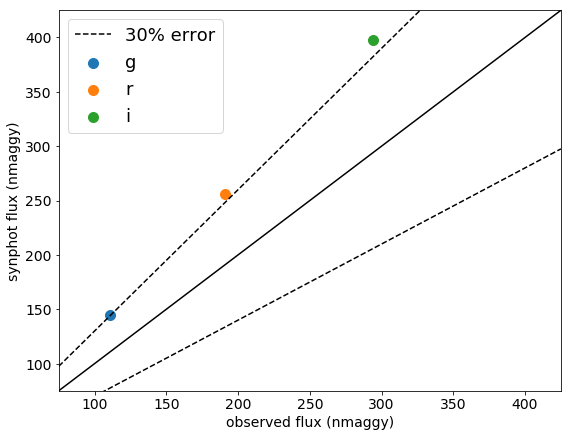

In [27]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(9, 7))

for band in sdss_bands:
    plt.scatter(sdss_fluxes[band], fluxes[band],
                s=100, label=band)

# one-to-one line
fluxrange = np.linspace(75, 425, 10)
plt.plot(fluxrange, fluxrange, color='black')
plt.plot(fluxrange, fluxrange * 0.7, color='black', ls='--', label='30% error')
plt.plot(fluxrange, fluxrange * 1.3, color='black', ls='--')

plt.ylabel('synphot flux (nmaggy)', size='14')
plt.xlabel('observed flux (nmaggy)', size='14')

plt.xlim(75, 425)
plt.ylim(75, 425)

plt.legend(prop={'size': 18})

All in all, not a bad prediction!